# Hodographic-shaping MGA transfer optimization with PyGMO

Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context 

This example illustrates the usage of PyGMO to optimize a low-thrust interplanetary transfer trajectory simulated using the multiple gravity assist (MGA) module of Tudat. The low-thrust legs are simulated using hodographic shaping. The spacecraft is considered to depart from the edge of the sphere of influence (SOI) of the Earth, execute swingbys at the Mars and Earth, and arrive at the edge of Jupiter's SOI. Thus, the transfer includes 3 legs and 2 swingbys.

The velocity directions of each hodographic-shaping leg are modeled using the recommended shaping functions and two additional shaping functions, resulting in 2 velocity-shaping free coefficients per direction per leg (i.e. 6 per leg). Some simplifications are considered when defining the departure/arrival velocity at each transfer node: the angles defining the orientation of the arrival/departure velocity and the angles defining the orbital plane of a swingby are all assumed to take the value 0. Additionally, no impulsive $\Delta V$ is considered to be applied during the swingbys.

The optimized parameters vector is constituted by the following variables:

* Departure date (1 variable)
* Magnitude of the departure excess velocity from Earth (1 variable)
* Magnitude of the arrival excess velocity at Jupiter (1 variable)
* Time of flight of each transfer leg (1 per leg, for a total of 3 variables)
* Magnitude of the arrival excess velocity at each swingby planet (1 per swingby, for a total of 2 variables)
* Altitude of the periapsis at each swingby (1 per swingby, for a total of 2 variables)
* Leg free coefficients per leg (6 per leg, for a total of 18 variables)
* Number of revolutions per leg (1 per leg, for a total of 3 variables)

Thus, a total of 31 variables is optimized.

The only objective function is the $\Delta V$, which is minimized.

PyGMO is used in this example. It is assumed that the reader of this tutorial is already familiar with the content of [this basic PyGMO tutorial](https://docs.tudat.space/en/latest/_src_advanced_topics/optimization_pygmo.html#about-pygmo).

## Import statements

The required import statements are made here. Some standard modules are first loaded (numpy, matplotlib and typing). The pygmo and multiprocessing libraries are also imported. Then, the different modules of tudatpy that will be used are imported. 

In [1]:
# General imports
import numpy as np
from typing import List, Tuple
import pygmo as pg
import matplotlib.pyplot as plt
import multiprocessing as mp

# Tudatpy imports
import tudatpy
from tudatpy.util import result2array
from tudatpy import constants
from tudatpy.numerical_simulation import environment_setup
from tudatpy.trajectory_design import shape_based_thrust, transfer_trajectory

## Helpers

First of all, let us define a helper function to create the MGA transfer object. Given some inputs, this function creates the transfer legs and nodes settings, and then uses them to create the transfer trajectory object. The function creates a transfer constituted by hodographic-shaping legs, selecting the shaping functions such that there are two free shaping coefficients per velocity direction per leg.

The function takes as inputs the usual parameters necessary for creating an MGA transfer object: the transfer body order, the departure orbit (semi-major axis and eccentricity), the arrival orbit (semi-major axis and eccentricity), the used system of bodies, and the name of the central body. Additionally, the function takes some more arguments used when defining the shaping functions: the time of flight per leg and the number of revolutions per leg.

The function returns the created transfer trajectory object.

In [2]:
def create_low_thrust_transfer_object(transfer_body_order: list,
                                      times_of_flight: np.ndarray,
                                      departure_semi_major_axis: float,
                                      departure_eccentricity: float,
                                      arrival_semi_major_axis: float,
                                      arrival_eccentricity: float,
                                      bodies: tudatpy.numerical_simulation.environment.SystemOfBodies,
                                      central_body: str,
                                      numbers_of_revolutions: List[int]) -> \
        tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory:

    # Create the list with the velocity shaping functions to use in each leg
    radial_velocity_function_components_per_leg = []
    normal_velocity_function_components_per_leg = []
    axial_velocity_function_components_per_leg = []

    for i in range(len(transfer_body_order)-1):
        tof = times_of_flight[i]
        frequency = 2.0 * np.pi / tof
        scale_factor = 1.0 / tof
        exponent = 4.0

        radial_velocity_functions = shape_based_thrust.recommended_radial_hodograph_functions(times_of_flight[i])
        radial_velocity_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
            exponent=1.0,
            frequency=0.5 * frequency,
            scale_factor=scale_factor))
        radial_velocity_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
            exponent=1.0,
            frequency=0.5 * frequency,
            scale_factor=scale_factor))
        radial_velocity_function_components_per_leg.append(radial_velocity_functions)

        normal_velocity_functions = shape_based_thrust.recommended_normal_hodograph_functions(times_of_flight[i])
        normal_velocity_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
            exponent=1.0,
            frequency=0.5 * frequency,
            scale_factor=scale_factor))
        normal_velocity_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
            exponent=1.0,
            frequency=0.5 * frequency,
            scale_factor=scale_factor))
        normal_velocity_function_components_per_leg.append(normal_velocity_functions)

        axial_velocity_functions = shape_based_thrust.recommended_axial_hodograph_functions(
            times_of_flight[i], numbers_of_revolutions[i])
        axial_velocity_functions.append(shape_based_thrust.hodograph_scaled_power_cosine(
            exponent=exponent,
            frequency=(numbers_of_revolutions[i] + 0.5) * frequency,
            scale_factor=scale_factor ** exponent))
        axial_velocity_functions.append(shape_based_thrust.hodograph_scaled_power_sine(
            exponent=exponent,
            frequency=(numbers_of_revolutions[i] + 0.5) * frequency,
            scale_factor=scale_factor ** exponent))
        axial_velocity_function_components_per_leg.append(axial_velocity_functions)

    # Create the transfer leg and node settings
    transfer_leg_settings, transfer_node_settings = transfer_trajectory.mga_settings_hodographic_shaping_legs(
        body_order=transfer_body_order,
        radial_velocity_function_components_per_leg=radial_velocity_function_components_per_leg,
        normal_velocity_function_components_per_leg=normal_velocity_function_components_per_leg,
        axial_velocity_function_components_per_leg=axial_velocity_function_components_per_leg,
        departure_orbit=(departure_semi_major_axis, departure_eccentricity),
        arrival_orbit=(arrival_semi_major_axis, arrival_eccentricity) )

    # Create the transfer trajectory object
    transfer_trajectory_object = transfer_trajectory.create_transfer_trajectory(
        bodies,
        transfer_leg_settings,
        transfer_node_settings,
        transfer_body_order,
        central_body)

    return transfer_trajectory_object

## Optimisation problem

The core of the optimization process is realized by PyGMO, which requires the definition of a problem class.
This definition has to be done in a class that is compatible with what the PyGMO library expects from a User Defined Problem (UDP). See [this page](https://esa.github.io/pygmo2/tutorials/coding_udp_simple.html) from the PyGMO's documentation as a reference. In this example, this class is called `MGAHodographicShapingTrajectoryOptimizationProblem`.

The following methods are implemented:

* `__init__()`: This is the constructor for the PyGMO problem class. It is used to save all the variables required to setup the creation and evaluation of the transfer trajectory.
* `get_bounds()`: Returns the bounds for each optimized parameter. These are provided as an input to `__init__()`. Their values are defined later in this example.
* `swingby_periapsis_to_optim_parameter()`: When it comes to the swingby periapsis altitude, the parameter that is optimized is the logarithm of the altitude, not the altitude itself. As such, this function converts the altitude to the optimized altitude parameter. This function can be modified to use a different scaling function (i.e. other than the logarithm).
* `optim_parameter_to_swingby_periapsis()`: This function executes the inverse of the transformation done by the `swingby_periapsis_to_optim_parameter` function. That is, it converts the optimized altitude parameter to the periapsis altitude.
* `get_nix()`: Returns the number of design variables which are to be optimized as integers. In this case, the only integer parameters are the number of revolutions per leg. 
* `get_transfer_trajectory_object()`: For a given vector of design parameters, the function returns the evaluated transfer trajectory object. This is useful to further analyze the transfer after the optimization, allowing e.g. to retrieve the state history.
* `get_node_times()`: For a given vector of design parameters, the function returns the transfer node times.
* `fitness()`: Returns the cost associated with a vector of design parameters. Here, the fitness is the $\Delta V$ required to execute the transfer. Each time this function is called, a new transfer trajectory object is created and evaluated using the specified design parameters.

In [3]:
#######################################################################
# Pygmo problem class
#######################################################################
class MGAHodographicShapingTrajectoryOptimizationProblem:
    """
    Class to initialize, simulate, and optimize an MGA transfer with hodographic-shaping low-thrust legs.
    """

    def __init__(self,
                 central_body: str,
                 transfer_body_order: List[str],
                 bounds: List[List[float]],
                 departure_semi_major_axis: float = np.inf,
                 departure_eccentricity: float = 0.0,
                 arrival_semi_major_axis: float = np.inf,
                 arrival_eccentricity: float = 0.0):
        """
        Class constructor.
        """

        self.transfer_body_order = transfer_body_order
        self.central_body = central_body

        self.no_of_swingbys = len(transfer_body_order) - 2
        self.no_of_legs = len(transfer_body_order) - 1

        # Number of free hodographic-shaping coefficients per leg, per velocity direction
        # Currently the value is 2. Can be modified if the create_low_thrust_transfer_object function is changed in
        # order to create hodographic legs with a different number of coefficients
        self.no_free_shaping_coefficients_per_velocity_direction = 2
        self.total_no_shaping_free_coefficients = self.no_free_shaping_coefficients_per_velocity_direction * 3 * self.no_of_legs

        self.bounds = bounds
        # Check if size of provided bounds is correct
        if len(self.bounds) != 2 or len(self.bounds[0]) != 8 or len(self.bounds[1]) != 8:
            raise RuntimeError("Size of provided parameters bounds is invalid.")

        self.departure_semi_major_axis = departure_semi_major_axis
        self.departure_eccentricity = departure_eccentricity
        self.arrival_semi_major_axis = arrival_semi_major_axis
        self.arrival_eccentricity = arrival_eccentricity

        self.current_transfer_trajectory_object = None
        self.current_node_times = None
        self.current_design_parameter_vector = None

        # Radius of solar system bodies, used to define the swingby periapsis radius.
        #
        # The values were retrieved from SPICE, using:
        # from tudatpy.interface import spice
        # spice.load_standard_kernels()
        # bodies_to_create = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]
        # planetary_radii = {}
        # for i in bodies_to_create:
        #     planetary_radii[i] = spice.get_average_radius(i)
        self.planetary_radii = {
            'Sun': 696000000.0,
            'Mercury': 2439699.9999999995,
            'Venus': 6051800.0,
            'Earth': 6371008.366666666,
            'Mars': 3389526.6666666665,
            'Jupiter': 69946000.0,
            'Saturn': 58300000.0,
            'Uranus': 25363666.666666668,
            'Neptune': 24623000.0 }

    def swingby_periapsis_to_optim_parameter(self, swingby_periapsis) -> float:
        """
        Converts the value of the swingby periapsis altitude to the parameter being optimized. The parameter being optimized
        is the log10 of the periapsis.
        """

        if swingby_periapsis <= 0:
            raise RuntimeError(f"Value for the swingby periapsis altitude should be larger than zero (it is {swingby_periapsis}).")

        return np.log10(swingby_periapsis)

    def optim_parameter_to_swingby_periapsis(self, optim_parameter) -> float:
        """
        Converts the value of the parameter being optimized to the swingby periapsis altitude. The parameter being optimized
        is the log10 of the periapsis.
        """

        return 10**optim_parameter

    def get_bounds(self) -> Tuple[list, list]:
        """
        Returns the bounds for the optimized parameters. For the integer parameters, the bounds should also be integers.
        """

        ################################################################################################################
        # Extract user-defined bounds

        # Departure date
        departure_date_lb = self.bounds[0][0]
        departure_date_ub = self.bounds[1][0]

        # Departure velocity (departure from initial node)
        departure_velocity_lb = self.bounds[0][1]
        departure_velocity_ub = self.bounds[1][1]

        # Arrival velocity (arrival to final node)
        arrival_velocity_lb = self.bounds[0][2]
        arrival_velocity_ub = self.bounds[1][2]

        # Time of flight per leg
        leg_time_of_flight_lb = self.bounds[0][3]
        leg_time_of_flight_ub = self.bounds[1][3]

        # Incoming velocity at swingby nodes
        swingby_incoming_velocity_lb = self.bounds[0][4]
        swingby_incoming_velocity_ub = self.bounds[1][4]

        # Swingby periapsis altitude
        swingby_periapsis_altitude_lb = self.swingby_periapsis_to_optim_parameter(self.bounds[0][5])
        swingby_periapsis_altitude_ub = self.swingby_periapsis_to_optim_parameter(self.bounds[1][5])

        # Free shaping coefficients of each leg
        leg_free_coefficients_lb = self.bounds[0][6]
        leg_free_coefficients_ub = self.bounds[1][6]

        # Number of revolutions per leg
        leg_number_of_revolutions_lb = self.bounds[0][7]
        leg_number_of_revolutions_ub = self.bounds[1][7]

        ################################################################################################################
        # Construct array with bounds of design parameter

        # Select lower bounds
        lower_bounds = []
        lower_bounds.append(departure_date_lb)
        lower_bounds.append(departure_velocity_lb)
        lower_bounds.append(arrival_velocity_lb)

        for _ in range(self.no_of_legs):
            lower_bounds.append(leg_time_of_flight_lb)
        for _ in range(self.no_of_swingbys):
            lower_bounds.append(swingby_incoming_velocity_lb)
        for _ in range(self.no_of_swingbys):
            lower_bounds.append(swingby_periapsis_altitude_lb)
        for _ in range(self.total_no_shaping_free_coefficients):
            lower_bounds.append(leg_free_coefficients_lb)
        for _ in range(self.no_of_legs):
            lower_bounds.append(leg_number_of_revolutions_lb)

        # Select upper bounds
        upper_bounds = []
        upper_bounds.append(departure_date_ub)
        upper_bounds.append(departure_velocity_ub)
        upper_bounds.append(arrival_velocity_ub)

        for _ in range(self.no_of_legs):
            upper_bounds.append(leg_time_of_flight_ub)
        for _ in range(self.no_of_swingbys):
            upper_bounds.append(swingby_incoming_velocity_ub)
        for _ in range(self.no_of_swingbys):
            upper_bounds.append(swingby_periapsis_altitude_ub)
        for _ in range(self.total_no_shaping_free_coefficients):
            upper_bounds.append(leg_free_coefficients_ub)
        for _ in range(self.no_of_legs):
            upper_bounds.append(leg_number_of_revolutions_ub)

        return lower_bounds, upper_bounds

    def get_nix(self):
        """
        Select the number of integer parameters in the problem. The integer parameters are the last elements of the
        design parameter vector. Here, only the numbers of revolutions per leg are considered to be integers.
        """
        return self.no_of_legs

    def get_transfer_trajectory_object(self,
                                       design_parameter_vector: np.ndarray) -> \
            tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory:
        """
        Function that creates a transfer trajectory object, evaluates it using the provided design parameter vector and
        return the evaluated transfer trajectory object.
        """

        if not (self.current_design_parameter_vector is not None and np.all(design_parameter_vector == self.current_design_parameter_vector)):
            self.fitness(design_parameter_vector, post_processing=True)
        return self.current_transfer_trajectory_object

    def get_node_times(self,
                       design_parameter_vector: np.ndarray) -> \
            tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory:
        """
        Function that creates a transfer trajectory object, evaluates it using the provided design parameter vector and
        returns the associated node times.
        """

        if not (self.current_design_parameter_vector is not None and np.all(design_parameter_vector == self.current_design_parameter_vector)):
            self.fitness(design_parameter_vector, post_processing=True)
        return self.current_node_times

    def fitness(self,
                design_parameter_vector: np.ndarray,
                post_processing: bool = False) -> List[float]:
        """
        Function to evaluate the fitness. A single-objective optimization is used, in which the objective is the deltaV
        necessary to execute the transfer.
        """

        # Compute the final index of each type of parameters
        time_of_flight_index = 3 + self.no_of_legs
        incoming_velocity_index = time_of_flight_index + self.no_of_swingbys
        swingby_periapsis_index = incoming_velocity_index + self.no_of_swingbys
        shaping_free_coefficient_index = swingby_periapsis_index + self.total_no_shaping_free_coefficients
        revolution_index = shaping_free_coefficient_index + self.no_of_legs

        ################################################################################################################
        # Extract floating point numbers from parameter vector

        # Departure date
        departure_date = design_parameter_vector[0]

        # Departure velocity
        departure_velocity = design_parameter_vector[1]

        # Arrival velocity
        arrival_velocity = design_parameter_vector[2]

        # Time of flight per leg
        times_of_flight = design_parameter_vector[3:time_of_flight_index]

        # Incoming velocities at each swingby node
        incoming_velocities = design_parameter_vector[time_of_flight_index:incoming_velocity_index]

        # Swingby periapsis at each swingby node
        swingby_periapse_altitudes = \
            [self.optim_parameter_to_swingby_periapsis(x) for x in design_parameter_vector[incoming_velocity_index:swingby_periapsis_index]]

        # hodographic shaping free coefficients
        shaping_free_coefficients = design_parameter_vector[swingby_periapsis_index:shaping_free_coefficient_index]

        ################################################################################################################
        # Extract integer numbers from parameter vector

        # Number of revolutions
        numbers_of_revolutions = \
            [int(x) for x in design_parameter_vector[shaping_free_coefficient_index:revolution_index]]

        ################################################################################################################
        # Create and evaluate the transfer trajectory

        # Create the system of bodies
        # This is done in the fitness function instead of the constructor so that the class can be pickled
        bodies = environment_setup.create_simplified_system_of_bodies()

        # Create the transfer trajectory object
        transfer_trajectory_object = create_low_thrust_transfer_object(
            self.transfer_body_order,
            times_of_flight,
            self.departure_semi_major_axis,
            self.departure_eccentricity,
            self.arrival_semi_major_axis,
            self.arrival_eccentricity,
            bodies,
            self.central_body,
            numbers_of_revolutions)

        # Create the node times
        node_times = []
        node_times.append(departure_date)
        for i in range(len(times_of_flight)):
            node_times.append(node_times[i] + times_of_flight[i])

        # Create the leg free parameters
        leg_free_parameters = []
        for i in range(self.no_of_legs):
            leg_free_coefficients = np.array(shaping_free_coefficients[
                                    i * self.no_free_shaping_coefficients_per_velocity_direction * 3 :
                                    (i + 1) * self.no_free_shaping_coefficients_per_velocity_direction * 3])
            leg_free_parameters.append([numbers_of_revolutions[i]] + leg_free_coefficients.tolist())

        # Create the node free parameters
        node_free_parameters = []

        # Departure node parameters
        # The excess velocity angles are taken to be 0.0
        node_free_parameters.append([departure_velocity, 0.0, 0.0])

        # Swingby nodes parameters
        # The excess velocity angles, swingby plane angle, and deltaV are taken to be 0.0
        for i in range(self.no_of_swingbys):
            swingby_body = self.transfer_body_order[1:-1][i]
            swingby_planetary_radius = self.planetary_radii[swingby_body]
            swingby_periapse_radius = swingby_planetary_radius + swingby_periapse_altitudes[i]
            node_free_parameters.append([incoming_velocities[i], 0.0, 0.0, swingby_periapse_radius, 0.0, 0.0])

        # Arrival node parameters
        # The excess velocity angles are taken to be 0.0
        node_free_parameters.append([arrival_velocity, 0.0, 0.0])

        # Evaluate the transfer and retrieve the delta V
        try:
            transfer_trajectory_object.evaluate(node_times, leg_free_parameters, node_free_parameters)
            objective = transfer_trajectory_object.delta_v

            # If in post-processing, save transfer trajectory object and node times
            if post_processing:
                self.current_design_parameter_vector = design_parameter_vector
                self.current_transfer_trajectory_object = transfer_trajectory_object
                self.current_node_times = node_times
            else:
                self.current_design_parameter_vector = None
                self.current_transfer_trajectory_object = None
                self.current_node_times = None
        # If an error was thrown while evaluating the transfer, assign a very large value to the objective function
        except RuntimeError:
            objective = 1e16

            # If in post-processing throw the error
            if post_processing:
                raise

        # Return the value of the objective function
        return [objective]

## Optimization

### Transfer Trajectory Setup 

Before running the optimisation, it is first necessary to select some of the properties of the transfer trajectory: the central body, the sequence of bodies, the departure orbit, and the arrival orbit. 

In [4]:
if __name__ == '__main__':
    ###########################################################################
    # Define transfer trajectory settings
    ###########################################################################

    # Simplified bodies
    central_body = 'Sun'

    # Define order of bodies (nodes) for gravity assists
    transfer_body_order = ['Earth', 'Mars', 'Earth', "Jupiter"]

    # Define departure and insertion orbit
    departure_semi_major_axis = np.inf
    departure_eccentricity = 0.0

    arrival_semi_major_axis = np.inf
    arrival_eccentricity = 0.0

### Optimization Setup 

Next, the bounds of the optimized parameters are selected. The bounds used here were not tuned, therefore further tuning them might allow better optimization results to be found.

The lower and upper bounds for the departure and arrival velocities are all taken to have the value 0; as such, these free variables are not optimized.

In [5]:
    ###########################################################################
    # Select optimization bounds
    ###########################################################################

    julian_day = constants.JULIAN_DAY

    # Select bounds
    departure_date_lb = 9000 * julian_day # s
    departure_date_ub = 9200 * julian_day # s
    departure_velocity_lb = 0.0 # m/s
    departure_velocity_ub = 0.0 # m/s
    arrival_velocity_lb = 0.0 # m/s
    arrival_velocity_ub = 0.0 # m/s
    leg_tof_lb = 200 * julian_day # s
    leg_tof_ub = 1200 * julian_day # s
    swingby_incoming_velocity_lb = 0 # m/s
    swingby_incoming_velocity_ub = 7000 # m/s
    swingby_periapsis_altitude_lb = 2e2 # m
    swingby_periapsis_altitude_ub = 2e11 # m
    leg_free_coefficient_lb = -1e4 # -
    leg_free_coefficient_ub = 1e4 # -
    leg_number_of_revolutions_lb = 0 # -
    leg_number_of_revolutions_ub = 4 # -

    bounds = [
        [departure_date_lb, departure_velocity_lb, arrival_velocity_lb, leg_tof_lb, swingby_incoming_velocity_lb,
         swingby_periapsis_altitude_lb, leg_free_coefficient_lb, leg_number_of_revolutions_lb],
        [departure_date_ub, departure_velocity_ub, arrival_velocity_ub, leg_tof_ub, swingby_incoming_velocity_ub,
         swingby_periapsis_altitude_ub, leg_free_coefficient_ub, leg_number_of_revolutions_ub]]

To setup the optimization, it is first necessary to initialize the optimization problem. This problem, defined through the class `MGAHodographicShapingTrajectoryOptimizationProblem`, is given to PyGMO trough the `pg.problem()` method.

The optimiser is selected to be the Simple Genetic Algorithm (SGA) algorithm (its documentation can be found [here](https://esa.github.io/pygmo2/algorithms.html#pygmo.sga)), and is created by calling `pg.algorithm()`. A fixed seed is used to ensure that the results are reproducible.

Since a large population is being optimized (1000 individuals), the `pg.island` class is used instead of `pg.population`. The island serves as a wrapper to the population, allowing the population to be evolved simultaneously in multiple threads, multiple processes, or even multiple machines. Here, as the type os island is not selected explicitly, usually the evolution will occur in multiple processes (though it depends on the operating systems), meaning that multiple CPUs will be used simultaneously. A seed is also specified when creating the island (this seed is used when creating the initial population).

In [6]:
    ###########################################################################
    # Setup optimization
    ###########################################################################

    seed = 42
    pop_size = 1000

    # Create Pygmo problem
    transfer_optimization_problem = MGAHodographicShapingTrajectoryOptimizationProblem(
        central_body, transfer_body_order, bounds, departure_semi_major_axis, departure_eccentricity,
        arrival_semi_major_axis, arrival_eccentricity)
    problem = pg.problem(transfer_optimization_problem)

    # Create algorithm and define its seed
    algorithm = pg.algorithm(pg.sga(gen=1))
    algorithm.set_seed(seed)

    # Create island
    island = pg.island(algo=algorithm, prob=problem, size=pop_size, seed=seed)

### Run Optimization 

Finally, the optimization can be executed by successively evolving the island. To do so, the method `island.evolve()` is called the desired number of times inside a loop. After starting each evolution of the island, the method `island.wait_check()` is called, which makes the program wait for all the evolutions running in parallel to finish. After each evolution is finished, the best fitness and parameters vector are saved.

In [7]:
    ###########################################################################
    # Run optimization
    ###########################################################################

    num_gen = 40

    # Initialize lists with the best individual per generation
    list_of_champion_f = [island.get_population().champion_f]
    list_of_champion_x = [island.get_population().champion_x]

    # freeze_support needs to be called when using multiprocessing on windows
    # If called from other operating systems, freeze_support doesn't have any effect
    mp.freeze_support()

    for i in range(num_gen):
        print('Evolution: %i / %i' % (i+1, num_gen))

        island.evolve() # Evolve island
        island.wait_check() # Wait until all evolution tasks in the island finish

        # Save current champion
        list_of_champion_x.append(island.get_population().champion_x)
        list_of_champion_f.append(island.get_population().champion_f)
    print('Evolution finished')

Evolution: 1 / 40
Evolution: 2 / 40
Evolution: 3 / 40
Evolution: 4 / 40
Evolution: 5 / 40
Evolution: 6 / 40
Evolution: 7 / 40
Evolution: 8 / 40
Evolution: 9 / 40
Evolution: 10 / 40
Evolution: 11 / 40
Evolution: 12 / 40
Evolution: 13 / 40
Evolution: 14 / 40
Evolution: 15 / 40
Evolution: 16 / 40
Evolution: 17 / 40
Evolution: 18 / 40
Evolution: 19 / 40
Evolution: 20 / 40
Evolution: 21 / 40
Evolution: 22 / 40
Evolution: 23 / 40
Evolution: 24 / 40
Evolution: 25 / 40
Evolution: 26 / 40
Evolution: 27 / 40
Evolution: 28 / 40
Evolution: 29 / 40
Evolution: 30 / 40
Evolution: 31 / 40
Evolution: 32 / 40
Evolution: 33 / 40
Evolution: 34 / 40
Evolution: 35 / 40
Evolution: 36 / 40
Evolution: 37 / 40
Evolution: 38 / 40
Evolution: 39 / 40
Evolution: 40 / 40
Evolution finished


## Results Analysis

Having finished the optimisation, it is now possible to analyse the results. An optimum of 41.7 km/s was found, which is a very significant improvement with respect to the best fitness in the initial population (above 200 km/s). The evolution of the minimum $\Delta V$ throughout the optimization is plotted.


########### CHAMPION INDIVIDUAL ###########

Total Delta V [m/s]:  43545.831395288056
Parameters vector [various]:  [ 7.80996883e+08  0.00000000e+00  0.00000000e+00  2.58495102e+07
  6.52561545e+07  7.72926114e+07  1.26835559e+02  3.25688083e+03
  1.06044638e+01  9.16093851e+00 -5.27626936e+03 -5.64389499e+02
 -9.49687225e+03  2.46759146e+03 -2.12123157e+03 -2.04282663e+02
 -8.16012459e+02  9.90566809e+03 -5.90041545e+03  2.72080705e+03
 -1.02444844e+03 -6.28446099e+03 -9.86182936e+03 -2.59895327e+03
 -9.70955023e+03 -2.14051547e+03 -3.64300937e+03 -2.72263066e+03
  0.00000000e+00  1.00000000e+00  0.00000000e+00]


Text(0, 0.5, '$\\Delta V$ [km/s]')

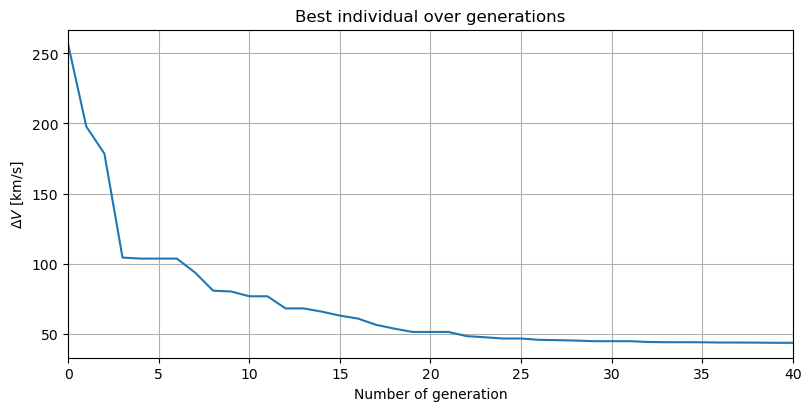

In [8]:
    ###########################################################################
    # Extract the best individual and plot fitness evolution
    ###########################################################################

    print('\n########### CHAMPION INDIVIDUAL ###########\n')
    print('Total Delta V [m/s]: ', island.get_population().champion_f[0])
    print("Parameters vector [various]: ", island.get_population().champion_x)

    # Plot fitness over generations
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    ax.plot(np.arange(0, num_gen+1), np.float_(list_of_champion_f) / 1000)

    # Prettify
    ax.set_xlim((0, num_gen))
    ax.grid('major')
    ax.set_title('Best individual over generations')
    ax.set_xlabel('Number of generation')
    ax.set_ylabel('$\Delta V$ [km/s]')


#### Plot the transfer

The transfer trajectory object associated with a given design parameter vector can be retrieved from the PyGMO problem class through the `get_transfer_trajectory_object` object. The returned object is already evaluated. Using the transfer trajectory object one can, for example, retrieve the state and thrust acceleration history throughout the transfer and plot them.

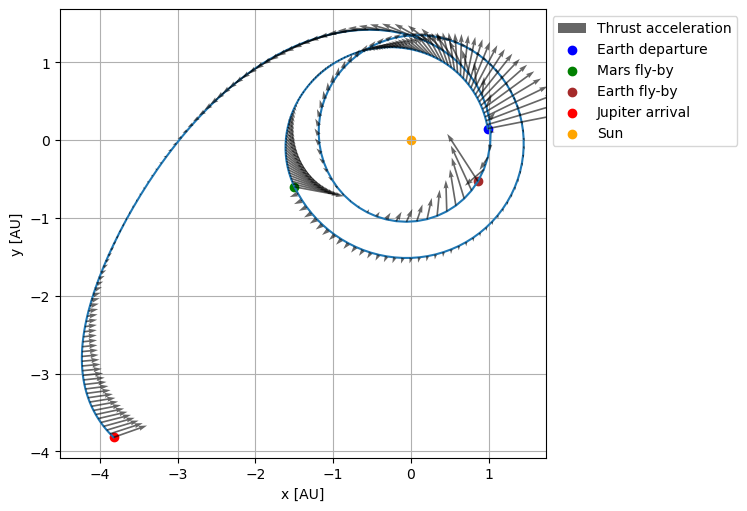

In [9]:
    ###########################################################################
    # Extract the champion trajectory object and plot trajectory
    ###########################################################################

    design_parameters = island.get_population().champion_x
    champion_transfer_trajectory_object = transfer_optimization_problem.get_transfer_trajectory_object(design_parameters)
    champion_node_times = transfer_optimization_problem.get_node_times(design_parameters)

    # Extract the state history
    state_history = champion_transfer_trajectory_object.states_along_trajectory(100)
    fly_by_states = np.array([state_history[champion_node_times[i]] for i in range(len(champion_node_times))])
    state_history = result2array(state_history)
    acceleration_history = champion_transfer_trajectory_object.inertial_thrust_accelerations_along_trajectory(100)
    acceleration_history = result2array(acceleration_history)
    au = 1.5e11

    # Plot the state history
    fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
    ax.plot(state_history[:, 1] / au, state_history[:, 2] / au)
    ax.quiver(state_history[:, 1] / au, state_history[:, 2] / au,
              acceleration_history[:, 1], acceleration_history[:, 2], label="Thrust acceleration", zorder=10, alpha=0.6)
    ax.grid()
    ax.scatter(fly_by_states[0, 0] / au, fly_by_states[0, 1] / au, color='blue', label='Earth departure')
    ax.scatter(fly_by_states[1, 0] / au, fly_by_states[1, 1] / au, color='green', label='Mars fly-by')
    ax.scatter(fly_by_states[2, 0] / au, fly_by_states[2, 1] / au, color='brown', label='Earth fly-by')
    ax.scatter(fly_by_states[3, 0] / au, fly_by_states[3, 1] / au, color='red', label='Jupiter arrival')
    ax.scatter([0], [0], color='orange', label='Sun')
    ax.set_xlabel('x [AU]')
    ax.set_ylabel('y [AU]')
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=[1, 1])